# Reducing circuit depth with the AQC-Tensor Qiskit addon

In this notebook, we will work through the steps of a [Qiskit pattern](https://quantum.cloud.ibm.com/docs/guides/intro-to-patterns) while using **approximate quantum compilation with tensor networks (AQC-Tensor)** to achieve a lower circuit depth than would ordinarily be needed to perform Trotter evolution.

These are the steps that we will take:

- **Step 1: Map to quantum problem**
    - Initialize our problem's Hamiltonian and observable(s)
    - <font color='#0F62FE'>Generate a target tensor-network state for the initial portion of the circuit</font>
    - <font color='#0F62FE'>Generate a low-depth circuit which approximates the portion being compressed</font>
    - <font color='#0F62FE'>Generate a general ansatz from that circuit</font>
    - <font color='#0F62FE'>Optimize the parameters to bring the ansatz as close as possible to the target</font>
    - <font color='#0F62FE'>Add subsequent Trotter steps to the optimized ansatz</font>
- **Step 2: Optimize for target hardware**
    - Transpile the circuit for hardware
- **Step 3: Execute experiments**
    - Use a fake backend for simplicity
- **Step 4: Reconstruct results**
    - N/A; instead, we just output the measured observable

## Step 1: Map to quantum circuit and operator

### Set up a model Hamiltonian and observable

In this notebook, we use the Ising model on a circle of 10 sites:
$$
\hat{\mathcal{H}}_{\text{Ising}} = \sum_{i=1}^{10} J_{i,(i+1)} Z_i Z_{(i+1)} + h_i X_i \, ,
$$
where the periodic boundary conditions imply that for $i=10$ we obtain $i+1=11\rightarrow1$, $J$ is the coupling strength between two sites and $h$ is the external magnetic field.

In [1]:
from qiskit.transpiler import CouplingMap
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian

# Generate some coupling map to use for this example
coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit circle on this coupling map
reduced_coupling_map = coupling_map.reduce([0, 13, 1, 14, 10, 16, 4, 15, 3, 9])

# Get a qubit operator describing the Ising field model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)

The observable we will measure is the total magnetization.

In [2]:
from qiskit.quantum_info import SparsePauliOp

L = reduced_coupling_map.size()
observable = SparsePauliOp.from_sparse_list([("Z", [i], 1 / L / 2) for i in range(L)], num_qubits=L)

### Determine how much of the time evolution to simulate classically

Our overall goal is to simulate time evolution of the above model Hamiltonian.  We do so by Trotter evolution, which we split into two portions:

1. An initial portion that is simulable with matrix product states (MPS).  We will "compile" this portion using AQC as presented in https://arxiv.org/abs/2301.08609.
2. A subsequent portion of the circuit that will be executed on hardware.

Let's plan to use AQC-Tensor to compress our time evolution circuit up to time $t=4$, then evolve using ordinary Trotter steps up to $t=5$.

### Generate circuits before and after split

Now that we have chosen to split at $t=4$, we will generate two circuits:

1. A "target" circuit for the AQC portion of the evolution, from $t_i=0$ to $t_f=4$.  Because this is being simulated by a tensor-network simulator, the number of layers affects execution time only by a constant factor, so we might as well use a generous number of layers to minimize Trotter error.

In [3]:
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = 4.0
aqc_target_num_trotter_steps = 45

aqc_target_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
    time=aqc_evolution_time,
)

2. A subsequent evolution circuit, which evolves from $t_i=4$ to $t_f=5$.  Because this is being run on quantum hardware, it is desirable to use as few Trotter layers as possible.

In [4]:
subsequent_evolution_time = 1.0
subsequent_num_trotter_steps = 5

subsequent_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
    time=subsequent_evolution_time,
)

For the sake of later comparison, let's also generate a third circuit: one that evolves for `aqc_evolution_time` but which has the same evolution time per Trotter step as the subsequent circuit.  This is the circuit we would have working with had we not used a generous number of Trotter steps for the target circuit.  We will refer to this as the _comparison circuit_.

In [5]:
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
aqc_comparison_num_trotter_steps

20

In [6]:
comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

### Generate an ansatz and initial parameters from a Trotter circuit with fewer steps

First, we construct a "good" circuit that has the same evolution time as the target circuit, but with fewer Trotter steps (and thus fewer layers).

Then we pass this "good" circuit to AQC-Tensor's `generate_ansatz_from_circuit` function.  This function analyzes the two-qubit connectivity of the circuit and returns two things:
1. a general, parametrized ansatz circuit with the same two-qubit connectivity as the input circuit; and,
2. parameters that, when plugged into the ansatz, yield the input (good) circuit.

Soon we will take these parameters and iteratively adjust them to bring the ansatz circuit as close as possible to the target MPS.

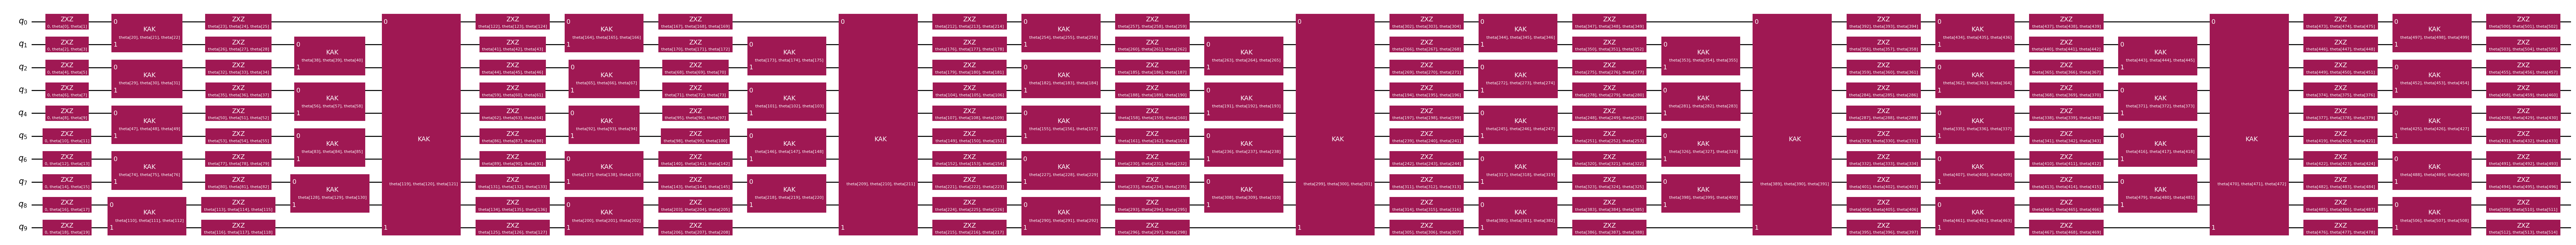

In [7]:
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz_num_trotter_steps = 5

aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit, qubits_initially_zero=True
)
aqc_ansatz.draw("mpl", fold=-1)

In [8]:
print(f"Comparison circuit: depth {comparison_circuit.depth()}")
print(f"Target circuit: depth {aqc_target_circuit.depth()}")
print(f"Ansatz circuit: depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")

Comparison circuit: depth 120
Target circuit: depth 270
Ansatz circuit: depth 23, with 515 parameters


### Choose settings for tensor network simulation

Here, we use the tensor network simulator based on [quimb](http://quimb.readthedocs.io/). In this example, we use quimb's matrix-product state (MPS) simulator, and we use [JAX](https://docs.jax.dev/en/latest/) for automatic differentiation. See the [API documentation](../stubs/qiskit_addon_aqc_tensor.simulation.quimb.QuimbSimulator.rst) for more information on how to use the quimb simulator.

In [9]:
from functools import partial

import quimb.tensor

from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.CircuitMPS, max_bond=100, cutoff=1e-8),
    autodiff_backend="jax",
)

### Construct matrix-product state representation of the AQC target state

Next, we build a matrix-product representation of the state to be approximated by AQC.

In [10]:
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mps = tensornetwork_from_circuit(aqc_target_circuit, simulator_settings)

Note that because we chose a generous number of Trotter steps for the target state, it actually has less Trotter error than the comparison circuit.  We can calculate the fidelity ($| \langle \psi_1 | \psi_2 \rangle |^2$) of the state prepared by the comparison circuit vs. the target state:

In [11]:
from qiskit_addon_aqc_tensor.simulation import compute_overlap

comparison_mps = tensornetwork_from_circuit(comparison_circuit, simulator_settings)
comparison_fidelity = abs(compute_overlap(comparison_mps, aqc_target_mps)) ** 2
comparison_fidelity

0.9996761790297157

### Optimize the parameters of the ansatz using MPS calculations

Here, we minimize the simplest possible cost function, `MaximizeStateFidelity`, by using the L-BFGS optimizer from scipy.

We choose a stopping point for the fidelity such that it will be above what the comparison circuit would have been, without using AQC.  Once this is reached, the compressed circuit has less Trotter error _and_ less depth than the original circuit.  Given more processing time, further optimization steps can be performed to bring the fidelity even higher.

In [12]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeStateFidelity

objective = MaximizeStateFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)

stopping_point = 1 - comparison_fidelity


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    objective.loss_function,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Intermediate result: Fidelity 0.95080335
Intermediate result: Fidelity 0.98408927
Intermediate result: Fidelity 0.99140876
Intermediate result: Fidelity 0.9951876
Intermediate result: Fidelity 0.99563147
Intermediate result: Fidelity 0.99646297
Intermediate result: Fidelity 0.99679298
Intermediate result: Fidelity 0.99715793
Intermediate result: Fidelity 0.99756604
Intermediate result: Fidelity 0.99804283
Intermediate result: Fidelity 0.99832283
Intermediate result: Fidelity 0.99856583
Intermediate result: Fidelity 0.99868698
Intermediate result: Fidelity 0.998867
Intermediate result: Fidelity 0.99902237
Intermediate result: Fidelity 0.99912174
Intermediate result: Fidelity 0.99919705
Intermediate result: Fidelity 0.99926724
Intermediate result: Fidelity 0.99938605
Intermediate result: Fidelity 0.99951297
Intermediate result: Fidelity 0.99956172
Intermediate result: Fidelity 0.99962274
Intermediate result: Fidelity 0.99963919
Intermediate result: Fidelity 0.99967423
Intermediate result

### Construct the final circuit to pass to the transpiler

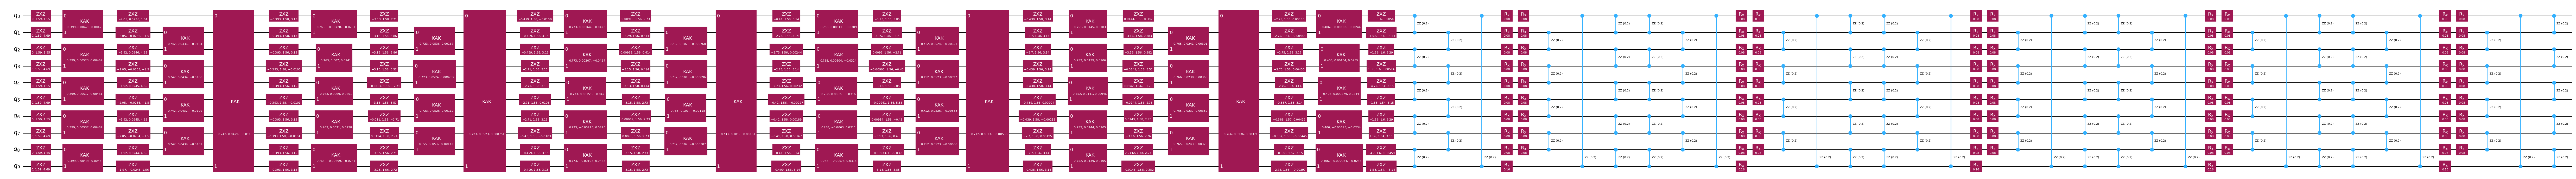

In [13]:
final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
final_circuit.compose(subsequent_circuit, inplace=True)
final_circuit.draw("mpl", fold=-1)

## Step 2: Transpile for execution on target hardware

In Step 2 of a [Qiskit pattern](https://quantum.cloud.ibm.com/docs/guides/intro-to-patterns), we  transpile this circuit and any desired observable(s) for execution on a target device.  Here we are using a fake backend provided by `qiskit-ibm-runtime`.

In [14]:
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2

backend = FakeMelbourneV2()

isa_circuit = transpile(final_circuit, backend)
isa_observable = observable.apply_layout(isa_circuit.layout)

The resulting ISA circuit can then be sent for execution on the backend (step 3 of a [Qiskit pattern](https://quantum.cloud.ibm.com/docs/guides/intro-to-patterns)).

## Step 3: Execute on quantum hardware

In [15]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend)
job = estimator.run([(isa_circuit, isa_observable)])
pub_result = job.result()[0]

## Step 4: Reconstruct

Reconstruction is not necessary in our case.  We can just look at the result.

In [16]:
pub_result.data.evs[()]

np.float64(0.047998046875000006)